In [ ]:
!pip install gdown
!pip install segmentation-models-pytorch

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1YQwBlGvqodie2zzurPIqZ7dswTHc6-9o'
output = 'MIDV-2020.zip'
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1YQwBlGvqodie2zzurPIqZ7dswTHc6-9o
To: /kaggle/working/MIDV-2020.zip
100%|██████████| 3.98G/3.98G [00:41<00:00, 95.5MB/s]


'MIDV-2020.zip'

In [3]:
!unzip MIDV-2020.zip >/dev/null
print('[INFO] The dataset has been unzipped...')

[INFO] The dataset has been unzipped...


In [4]:
import cv2
import os
import torch
import wandb
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from segmentation_models_pytorch import utils

In [12]:
# WandB – Login to your wandb account so you can log all your metrics
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
TRAIN_PATH = os.path.join('MIDV-2020', 'train')
TEST_PATH = os.path.join('MIDV-2020', 'test')

I_TRAIN_PATH = os.path.join(TRAIN_PATH, 'images')
M_TRAIN_PATH = os.path.join(TRAIN_PATH, 'masks')
I_TEST_PATH = os.path.join(TEST_PATH, 'images')
M_TEST_PATH = os.path.join(TEST_PATH, 'masks')

LABELS = os.listdir(I_TRAIN_PATH)

In [6]:
def get_data(mode):
    i_paths = []
    m_paths = []
    for label in LABELS:
        if mode == 'train':
            i_labels_path = os.path.join(I_TRAIN_PATH, label)
            m_labels_path = os.path.join(M_TRAIN_PATH, label)
        else:
            i_labels_path = os.path.join(I_TEST_PATH, label)
            m_labels_path = os.path.join(M_TEST_PATH, label)
            
        images = os.listdir(i_labels_path)
        masks = os.listdir(m_labels_path)
        
        for i in images:
            i_paths.append(os.path.join(i_labels_path, i))
        for m in masks:
            m_paths.append(os.path.join(m_labels_path, m))
    
    return sorted(i_paths), sorted(m_paths)

In [7]:
class Dataset(BaseDataset):
    def __init__(self, images, masks, image_size=512, augmentation=None):
        self.images = images
        self.masks = masks
        self.image_size = image_size
        self.augmentation = augmentation
    
    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], 0)
        
        image = cv2.resize(image, (self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)
        mask = mask / 255
        
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)
            
        return image, mask
    
    def __len__(self):
        return len(self.images)

In [8]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [9]:
TRAIN_IMAGES, TRAIN_MASKS = get_data('train')
TEST_IMAGES, TEST_MASKS = get_data('test')

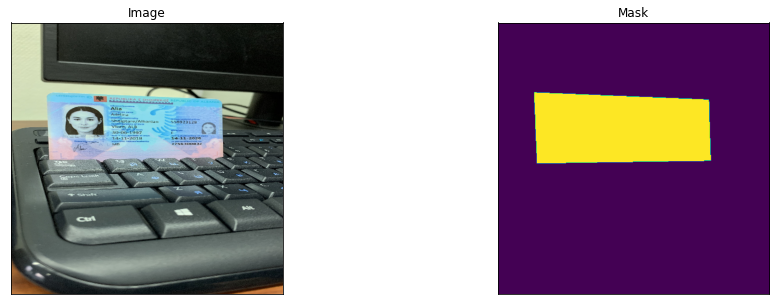

In [10]:
# Lets look at data we have
dataset_vis = Dataset(
    TRAIN_IMAGES, 
    TRAIN_MASKS
)

image, mask = dataset_vis[4] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [113]:
def get_training_augmentation():
    transforms = [
        A.RandomRotate90(p=0.5),
        A.GaussNoise(p=0.3),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=10, p=1),
            A.CLAHE(p=1)
        ], p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=1),
            A.ISONoise(p=1),
        ], p=0.9),
        A.OneOf([
            A.Rotate(limit=25, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1),
            A.Perspective(pad_mode=cv2.BORDER_CONSTANT, pad_val=0, mask_pad_val=0, fit_output=True, p=1)
        ], p=0.5),
        A.Normalize(),
        ToTensorV2()
    ]
    return A.Compose(transforms)

def get_validation_augmentation():
    transforms = [
        A.Normalize(),
        ToTensorV2()
    ]
    return A.Compose(transforms)

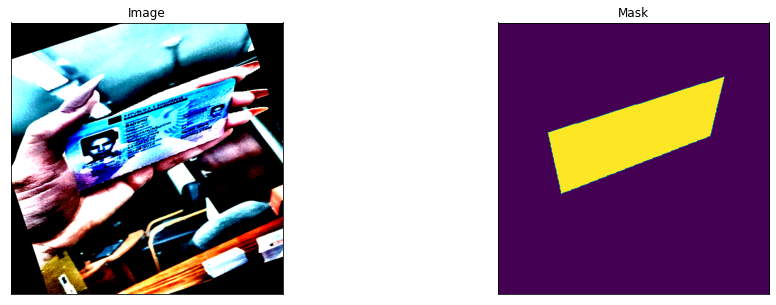

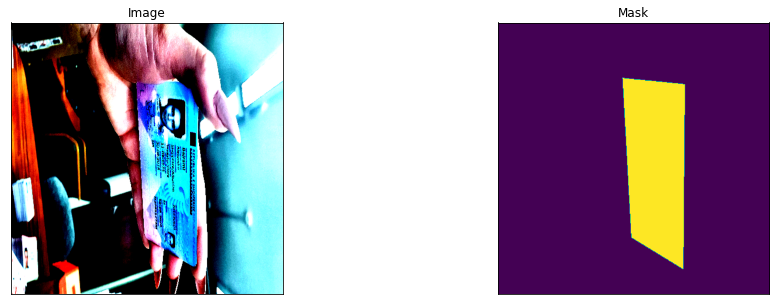

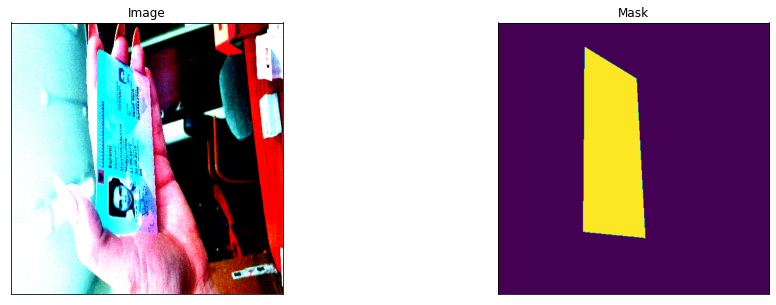

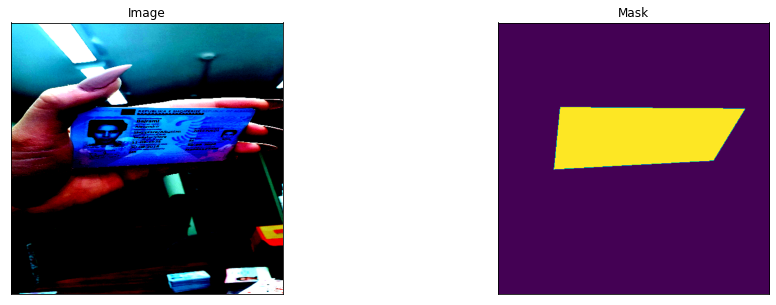

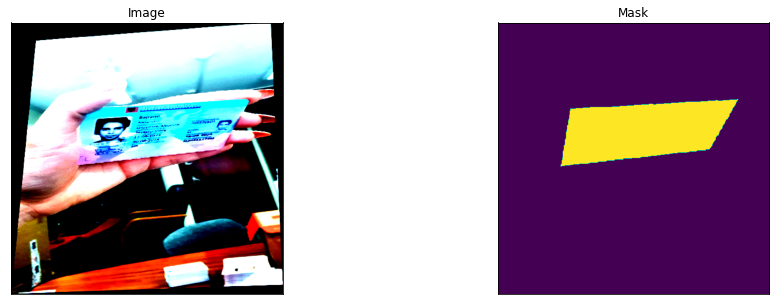

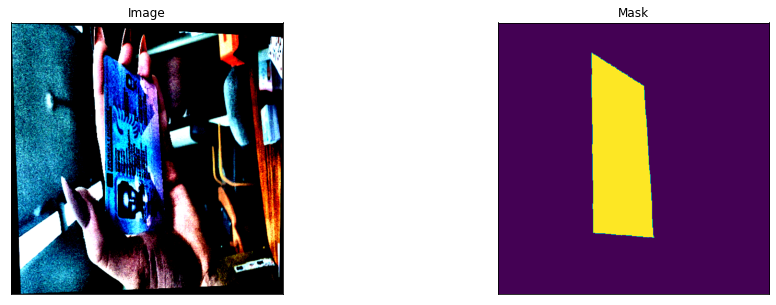

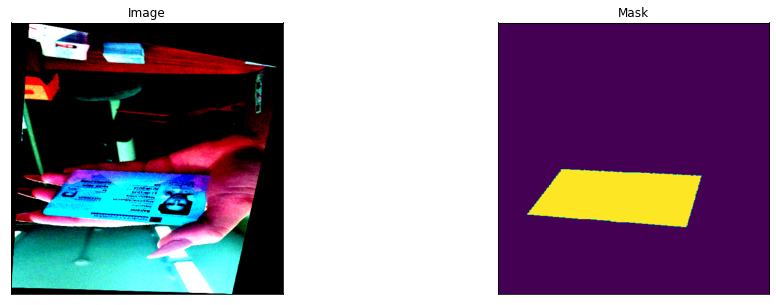

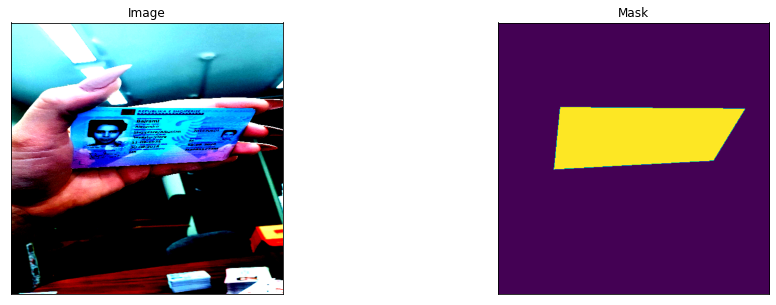

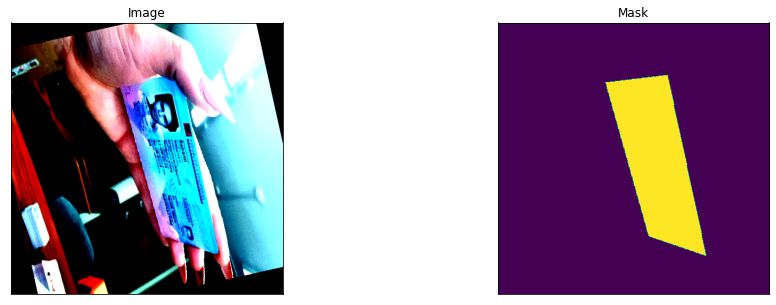

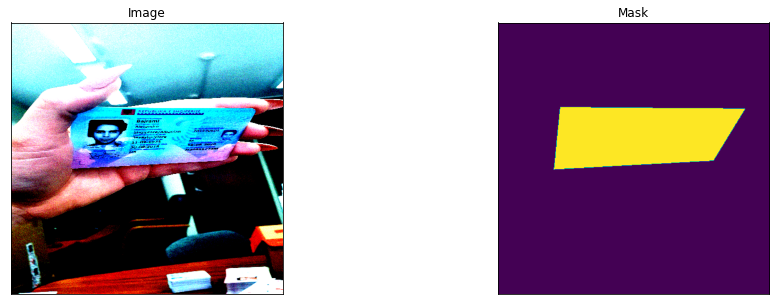

In [114]:
# Visualize resulted augmented images and masks
augmented_dataset = Dataset(
    TRAIN_IMAGES, 
    TRAIN_MASKS,
    augmentation=get_training_augmentation()
)

# same image with different random transforms
for i in range(10):
    image, mask = augmented_dataset[12]
    image = image.swapaxes(0,1)
    image = image.swapaxes(1,2)
    visualize(image=image, mask=mask.squeeze())

In [13]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['document']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
train_dataset = Dataset(
    TRAIN_IMAGES,
    TRAIN_MASKS,
    augmentation=get_training_augmentation()
)

valid_dataset = Dataset(
    TEST_IMAGES,
    TEST_MASKS,
    augmentation=get_validation_augmentation()
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=os.cpu_count())
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=os.cpu_count())

print('Train Dataset Size: {}'.format(len(train_dataset)))
print('Valid Dataset Size: {}'.format(len(valid_dataset)))

Train Dataset Size: 800
Valid Dataset Size: 200


In [15]:
loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(),
    utils.metrics.Fscore(),
    utils.metrics.Accuracy(),
    utils.metrics.Recall(),
    utils.metrics.Precision()
]

optimizer = torch.optim.Adam(
    params=model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08
)

In [ ]:
# download latest checkpoint
url = 'https://drive.google.com/uc?id=1klyJAl56zlOL1DNFXwFvOIwu44oeEXW7'
output = 'latest_checkpoint.pth'
gdown.download(url, output)

In [16]:
# load latest checkpoint if exists
if os.path.isfile('latest_checkpoint.pth'):
    model.to(DEVICE)
    checkpoint = torch.load('latest_checkpoint.pth', map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_iou = checkpoint['best_iou']
    print('Latest checkpoint found! Starting from epoch {}.'.format(start_epoch))
else:
    start_epoch = 0
    best_iou = 0
    print('No latest checkpoint. Starting from epoch 0.')

No latest checkpoint. Starting from epoch 0.


In [17]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=False,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=False,
)

In [18]:
# create test dataset
test_augmented_dataset = Dataset(
    TEST_IMAGES, 
    TEST_MASKS,
    augmentation=get_validation_augmentation()
)

valid_dataset = Dataset(
    TEST_IMAGES,
    TEST_MASKS,
    augmentation=get_validation_augmentation()
)

# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    TEST_IMAGES,
    TEST_MASKS
)

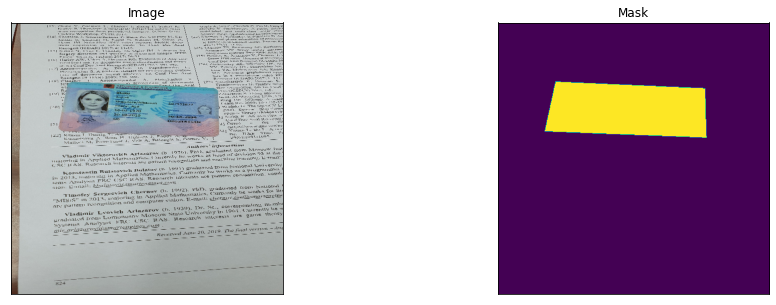

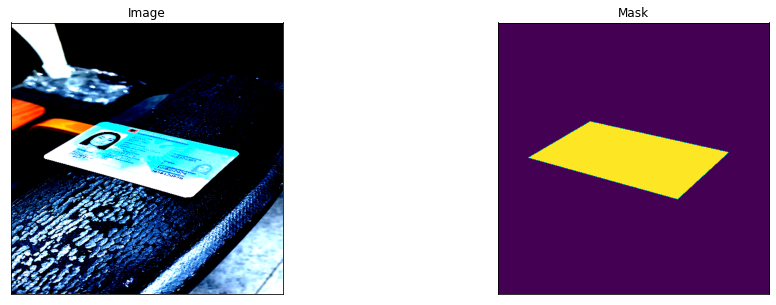

In [19]:
image, mask = test_dataset_vis[4] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

image, mask = test_augmented_dataset[1]
image = image.swapaxes(0,1)
image = image.swapaxes(1,2)
visualize(image=image, mask=mask.squeeze())

In [38]:
def get_result(rows, model, dataset):
    r = []
    
    for i in range(rows):
        im = []
        for j in range(3):
            n = np.random.choice(len(dataset))
            image, gt_mask = dataset[n] 
            
            image_vis = image.squeeze().cpu().numpy()
            image_vis = (255 * (image_vis - np.min(image_vis)) / np.ptp(image_vis)).astype(int)  
            image_vis = np.moveaxis(image_vis, 0, -1)
    
            gt_mask = gt_mask.squeeze().cpu().numpy().round()
            gt_mask = gt_mask.astype('uint8') * 255
            gt_mask = cv2.merge((gt_mask, gt_mask, gt_mask))
    
            x_tensor = torch.from_numpy(image.detach().cpu().numpy()).to(DEVICE).unsqueeze(0)
            pr_mask = model.predict(x_tensor)
            pr_mask = (pr_mask.squeeze().cpu().numpy().round())
            pr_mask = pr_mask.astype('uint8') * 255
            pr_mask = cv2.merge((pr_mask, pr_mask, pr_mask))
            
#             im.append((image_vis, gt_mask, pr_mask))
            im.append(image_vis)
            im.append(gt_mask)
            im.append(pr_mask)
    
        r.append(np.hstack(im))
        
    result = np.uint8(np.vstack(r))
    print(result.dtype)
    width = int(result.shape[1] * 0.33)
    height = int(result.shape[0] * 0.33)
    result = cv2.resize(result, (width, height))
    
    #return #wandb.Image(np.vstack((r[0], r[1], r[2], r[3], r[4], r[5], r[6], r[7], r[8], r[9])))
    return result

In [45]:
def save_checkpoint(epoch, model, optimizer, best_iou, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_iou': best_iou
    }, path)

In [ ]:
# generate new id for new run
id = wandb.util.generate_id()
print(id)

In [46]:
def format_metrics(metrics):
    logs = ['{} - {:.4}'.format(k, v) for k, v in metrics.items()]
    return ', '.join(logs)

In [ ]:
# WandB – Start or resume a run
# wandb.init(entity='jsun-dev', project='midv-segmentation', name='unet-resnet50',
#            id='3m1etobr', resume='allow')
# wandb.watch(model, log='all')

best_epoch = 0
best_logs = {}

for i in range(start_epoch, 50):
    train_logs = train_epoch.run(train_loader)
    print('Epoch: {} - train [{}]'.format(i, format_metrics(train_logs)))
    
    valid_logs = valid_epoch.run(valid_loader)
    print('Epoch: {} - valid [{}]'.format(i, format_metrics(valid_logs)))
    
    # save best checkpoint
    if valid_logs['iou_score'] >= best_iou:
        best_epoch = i
        best_iou = valid_logs['iou_score']
        best_logs = valid_logs
#         wandb.run.summary['best_epoch'] = best_epoch
#         wandb.run.summary['best_dice_loss'] = best_logs['dice_loss']
#         wandb.run.summary['best_iou_score'] = best_logs['iou_score']
#         wandb.run.summary['best_fscore'] = best_logs['fscore']
#         wandb.run.summary['best_accuracy'] = best_logs['accuracy']
#         wandb.run.summary['best_recall'] = best_logs['recall']
#         wandb.run.summary['best_precision'] = best_logs['precision']
        save_checkpoint(i, model, optimizer, best_iou, 'best_checkpoint.pth')
        print('Improved checkpoint saved!')
    
    # save latest checkpoint every epoch
    save_checkpoint(i, model, optimizer, best_iou, 'latest_checkpoint.pth')
    
    # save checkpoint every 10 epoch
    if (i + 1) % 10 == 0:
        save_checkpoint(i, model, optimizer, best_iou, 'checkpoint_{}.pth'.format(i))
    
#     # log metrics
#     wandb.log({
#         'train/dice_loss': train_logs['dice_loss'],
#         'train/iou_score': train_logs['iou_score'],
#         'train/fscore': train_logs['fscore'],
#         'train/accuracy': train_logs['accuracy'],
#         'train/recall': train_logs['recall'],
#         'train/precision': train_logs['precision'],
#         'valid/dice_loss': valid_logs['dice_loss'],
#         'valid/iou_score': valid_logs['iou_score'],
#         'valid/fscore': valid_logs['fscore'],
#         'valid/accuracy': valid_logs['accuracy'],
#         'valid/recall': valid_logs['recall'],
#         'valid/precision': valid_logs['precision'],
#         'result/train': get_result(10, model, 'train'),
#         'result/valid': get_result(10, model, 'valid')
#     })

# wandb.run.finish()


Epoch: 0
Epoch: 0 - train [dice_loss - 0.5107, iou_score - 0.6658, fscore - 0.7829, accuracy - 0.8865, recall - 0.9734, precision - 0.6718]
Epoch: 0 - valid [dice_loss - 0.4298, iou_score - 0.8534, fscore - 0.9207, accuracy - 0.969, recall - 0.9975, precision - 0.8552]
Improved checkpoint saved!

Epoch: 1
Epoch: 1 - train [dice_loss - 0.4062, iou_score - 0.9024, fscore - 0.9483, accuracy - 0.981, recall - 0.9922, precision - 0.9091]
Epoch: 1 - valid [dice_loss - 0.3619, iou_score - 0.9385, fscore - 0.9682, accuracy - 0.9882, recall - 0.9973, precision - 0.9408]


In [ ]:
# load best saved checkpoint
best_checkpoint = torch.load('best_checkpoint.pth')
model.load_state_dict(best_checkpoint['model_state_dict'])

In [ ]:
for i in range(5):  
    n = np.random.choice(len(test_dataset_vis))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_augmented_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image.detach().cpu().numpy()).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )